In [11]:
import yfinance as yf
import pypfopt as opt
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

headers = ['Company name', 'Stock symbol', 'Currency', 'Current price', 'Buy/sell', 'Buy/sell price', 'Qty. shares', 'Buy/sell date', 'Target price', 'Stop loss', 'Country', 'Sector', 'Ghosal sector', 'Weight', 'Standardised current price', 'Standardised buy/sell price', 'P&L', 'Return']

# date will be added to exported file
# today_date = datetime.today().strftime('%Y-%m-%d')

# reading in portfolio spreadsheet as pandas dataframe
df = pd.read_excel('portfolio.xlsx', index_col=False)
df.head()


,Company name,Stock symbol,Currency,Current price,Buy/sell,Buy/sell price,Qty. shares,Buy/sell date,Target price,Stop loss,Country,Sector,Ghosal Sector,Weight,Standardised current price,Standardised buy/sell price,P&L,Return
0,Microsoft Corporation,MSFT,USD,376.17,buy,NaN,1,2023-11-16,NaN,NaN,United States,Technology,NaN,NaN,NaN,NaN,NaN,NaN
1,Caterpillar Inc.,CAT,USD,248.53,buy,NaN,1,2023-11-16,NaN,NaN,United States,Industrials,NaN,NaN,NaN,NaN,NaN,NaN
2,3M Company,MMM,USD,95.57,buy,NaN,1,2023-11-16,NaN,NaN,United States,Industrials,NaN,NaN,NaN,NaN,NaN,NaN
3,McDonald's Corporation,MCD,USD,276.04,buy,NaN,1,2023-11-16,NaN,NaN,United States,Consumer Cyclical,NaN,NaN,NaN,NaN,NaN,NaN
4,"The Goldman Sachs Group, Inc.",GS,USD,336.67,buy,NaN,1,2023-11-16,NaN,NaN,United States,Financial Services,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
symbols = df['Stock symbol']
symbols_str = ''.join(symbol + ' ' for symbol in symbols)
latest_prices = df['Current price']


# handles data parameters for yf.download(), all you need to do is adjust how far back you want to go
years_back = 5
today_date_raw = datetime.today()
start_date_raw = today_date_raw - relativedelta(years=years_back)
today_date = today_date_raw.strftime('%Y-%m-%d')
start_date = start_date_raw.strftime('%Y-%m-%d')


data = yf.download(symbols_str, start=start_date,end=today_date)
prices = data['Adj Close']
prices



[*********************100%%**********************]  5 of 5 completed


,CAT,GS,MCD,MMM,MSFT
Date,,,,,
2018-12-17,110.195908,149.182892,161.042969,157.682983,97.704048
2018-12-18,110.018852,152.281799,160.080963,159.105911,98.729614
2018-12-19,108.301338,150.283905,159.591019,155.344177,98.463722
2018-12-20,107.610786,149.538040,154.709564,153.234283,96.393600
2018-12-21,106.300507,142.114883,155.128250,150.265778,93.278923
...,...,...,...,...,...
2023-12-11,260.920013,351.760010,289.149994,103.160004,371.299988
2023-12-12,261.429993,352.609985,291.420013,102.559998,374.380005
2023-12-13,267.970001,362.730011,295.929993,104.190002,374.369995


In [13]:
# returns Pandas series - vector
expected_returns = opt.expected_returns.mean_historical_return(prices)
expected_returns

CAT     0.210299
GS      0.206309
MCD     0.122922
MMM    -0.074769
MSFT    0.306211
dtype: float64

<Axes: >

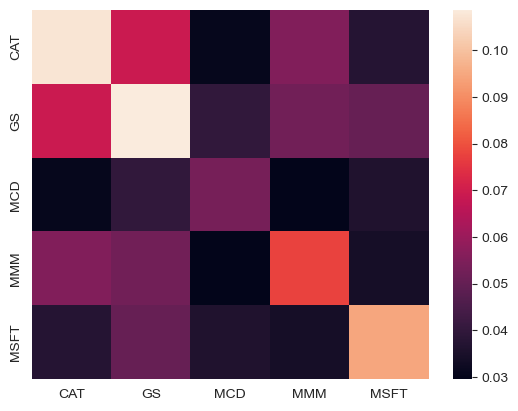

In [14]:

# covariance matrix of asset returns
return_cov = opt.risk_models.sample_cov(prices)
sns.heatmap(return_cov, cmap='rocket')


In [15]:
from pypfopt import plotting
# assuming we're using Conditional Value at Risk (CVaR) for efficient frontier
# class methods in efficient_frontier classes return optimal portfolio weights as OrderedDict

# fig, ax = plt.subplots()
# plotting.plot_efficient_frontier(ec, ef_param='risk', ef_param_range='min_cvar', ax=ax, show_assets=True)
plt.show()

#EFFICIENT FRONTIER
# to plot the entire frontier, pass the EfficientFrontier object into the plotting function BEFORE calling an optimisation function like ef.min_volatility(). it doesn't like it when you don't


# ef = opt.EfficientFrontier(expected_returns, return_cov)
# # ef.add_objective(opt.objective_functions().CVaR(alpha=0.05))
# fig, ax = plt.subplots()
# plotting.plot_efficient_frontier(ef, ef_param='return', ax=ax, show_assets=True)
# plt.show()



class parameter details
ef = EfficientCVaR(expected_returns(np array), returns(pd df), beta=0.95, weight_bounds=(0,1), solver=None(string, optional), verbose=False, solver_options=None)

note: success with regular EfficientFrontier. EfficientCVaR gives weights but won't let me plot the efficient frontier at all.

In [16]:
ec = opt.EfficientCVaR(expected_returns, return_cov, weight_bounds=(0, 1))

cvar_weights = ec.min_cvar()
ec.portfolio_performance(verbose=True)

latest_prices = prices.iloc[-1]

# here, weights should be an OrderedDict generated by an efficient_frontier class
da = opt.DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=15000, short_ratio=None)


# greedy portfolio vs. integer programming
# greedy portfolio: buys as many shares as possible for each asset without going over desired weight, then bin packs the remainder, prioritising assets w/ the biggest diff. between their current weight and ideal weight
# tradeoff between optimal and computational efficiency
allocation, leftover = da.greedy_portfolio()
print(f"Discrete allocation: {allocation}")
print(f"Funds remaining: ${leftover:.2f}")

Expected annual return: 16.7%
Conditional Value at Risk: -4.46%
Discrete allocation: {'GS': 23, 'MCD': 20, 'MMM': 4}
Funds remaining: $74.95


C:\Users\EYKS\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


<Axes: >

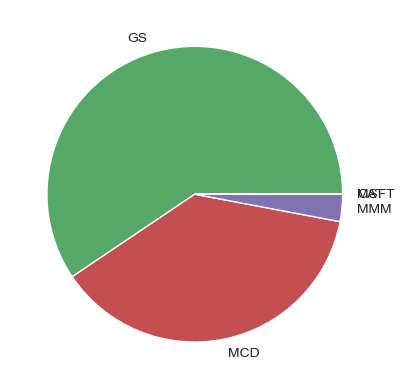

In [19]:
pd.Series(cvar_weights).plot.pie()